In [1]:
# import libraries
import scipy.io 
import os
import pandas as pd
import seaborn as sns
import neurokit2 as nk
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from scipy import stats
from statsmodels.stats.anova import AnovaRM

import numpy as np
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:
# with open("/Users/anna/Downloads/Scriptie_code/Code/notebooks/results_by_personality_2.pkl", "rb") as f:
#     results_by_personality = pickle.load(f)

with open("/Users/anna/Downloads/Scriptie_code/Code/notebooks/Amigos_results_rawlabels2.pkl", "rb") as f:
    results_by_personality = pickle.load(f)

# merged_short = pd.read_pickle("/Users/anna/Downloads/Scriptie_code/Code/short_features_pipeline.pkl")
# merged_long  = pd.read_pickle("/Users/anna/Downloads/Scriptie_code/Code/long_features_pipeline.pkl")
    

# Regression results

In [3]:
# build a list of rows with (setting, algorithm, task, R2, MAE, RMSE)
rows = []
for setting, met in results_by_personality.items():
    reg = met["results"]["regression"]
    for (algo, combo), info in reg.items():
        m = info["metrics"]        # this is your metrics dict
        rows.append({
            "setting"   : setting,
            "algorithm" : algo,
            "task"      : combo,
            "R²"        : m["r2"],
            "MAE"       : m["mae"],
            "RMSE"      : m["rmse"]
        })

# Turn into a DataFrame and index by setting→algorithm→task
metrics_df = (
    pd.DataFrame(rows)
      .set_index(["setting","algorithm","task"])
      .sort_index()
)

print(metrics_df)

                                        R²       MAE      RMSE
setting  algorithm task                                       
Clusters RF        long-arousal  -0.187621  1.721383  1.937718
                   long-valence  -0.025066  1.844315  2.081889
                   short-arousal -0.045982  1.503829  1.851985
                   short-valence -0.014085  1.812727  2.069734
         SVR       long-arousal  -0.022195  1.549666  1.797706
                   long-valence  -0.020967  1.809927  2.077722
                   short-arousal -0.006925  1.518494  1.817079
                   short-valence -0.005157  1.790356  2.060603


<Figure size 640x480 with 0 Axes>

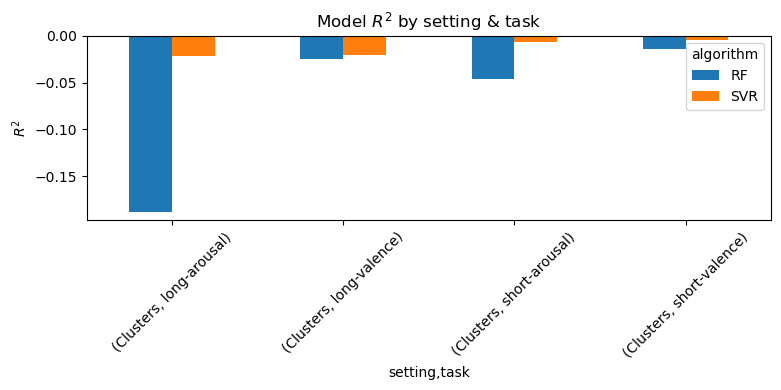

In [4]:
# en plot:
# pivot the table so each setting, task is a group of bars per algorithm
r2_pivot = metrics_df["R²"].unstack(level="algorithm")
mae_pivot = metrics_df["MAE"].unstack(level="algorithm")
rmse_pivot = metrics_df["RMSE"].unstack(level="algorithm")

# plot rsquared
plt.figure()
r2_pivot.plot(kind="bar", rot=45, figsize=(8,4))
plt.ylabel("$R^2$")
plt.title("Model $R^2$ by setting & task")
plt.tight_layout()
plt.show()

And on smallest RMSE:

In [5]:
# models, ranked by RMSE, ascending
best_by_r2= metrics_df.sort_values(by="R²", ascending=False)
print(best_by_r2.head(10))

                                        R²       MAE      RMSE
setting  algorithm task                                       
Clusters SVR       short-valence -0.005157  1.790356  2.060603
                   short-arousal -0.006925  1.518494  1.817079
         RF        short-valence -0.014085  1.812727  2.069734
         SVR       long-valence  -0.020967  1.809927  2.077722
                   long-arousal  -0.022195  1.549666  1.797706
         RF        long-valence  -0.025066  1.844315  2.081889
                   short-arousal -0.045982  1.503829  1.851985
                   long-arousal  -0.187621  1.721383  1.937718


## plot predicted against actual y
Adjust color_by to either VideoID or group

KeyError: 'no_personality'

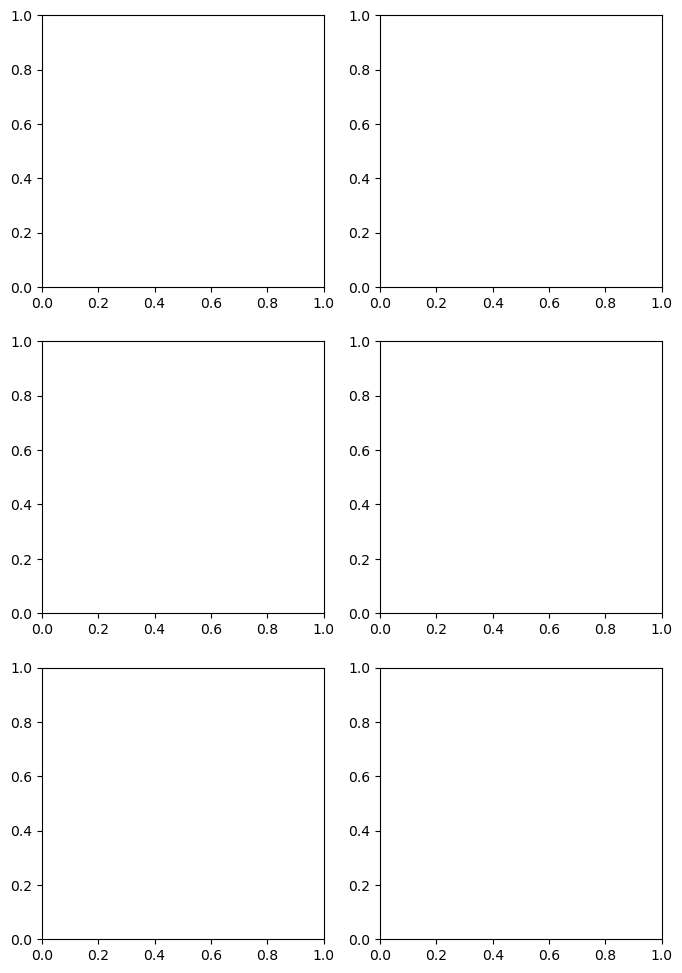

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

settings = ["no_personality", "traits", "PC_clusters"]
tasks_by_type = {
    "arousal": ["short-arousal", "long-arousal"],
    "valence": ["short-valence", "long-valence"]
}
algo      = "SVR"
color_by  = "group"          # or "VideoID"
cmap      = plt.get_cmap("tab20")

label_mapping = {
    "No_personality": "Baseline",
    "Traits"        : "Traits",
    "Clusters"   : "Clusters"
}

for measure, tasks in tasks_by_type.items():
    fig, axes = plt.subplots(
        nrows=len(settings),
        ncols=len(tasks),
        figsize=(4 * len(tasks), 4 * len(settings)),
        squeeze=False
    )

    for i, setting in enumerate(settings):
        nice_setting = label_mapping[setting]          # → Baseline / Traits / Clusters
        for j, task in enumerate(tasks):
            ax  = axes[i][j]
            met = results_by_personality[setting]["results"]["regression"][(algo, task)]["metrics"]

            df = pd.DataFrame({
                "y_true" : met["y_true"],
                "y_pred" : met["y_pred"],
                "group"  : met["groups"],
                "VideoID": met["y_video"]
            })

            # neat task name: "short-arousal" → "Short Arousal"
            nice_task = task.replace("-", " ").title()

            # scatter, coloured by group/VideoID
            for idx, key in enumerate(df[color_by].unique()):
                sub = df[df[color_by] == key]
                ax.scatter(sub.y_true, sub.y_pred,
                           color=cmap(idx % cmap.N), alpha=0.6)

            # y = x reference
            lo, hi = df.y_true.min(), df.y_true.max()
            ax.plot([lo, hi], [lo, hi], "--", c="gray")

            ax.set_xlabel(r"True $y$")
            ax.set_ylabel(r"Predicted $\hat y$")

            # subplot title: "<Setting> — <Task>"
            ax.set_title(f"{nice_setting} — {nice_task}", fontsize=9)

    # fig.suptitle(f"{algo} — True vs Predicted ({measure.title()})", y=1.02)
    plt.tight_layout()
    plt.show()


what we see:
1. extremes are under-predicted: in all panels, the points lies in a narrow band around 0. this means the model almost always just predicts 0. The random forest lacks the features or isn't flexible enough to capture more extremes. 
2. long vs short: long arousal tends to be even more compressed, short videos show a bit more spread, but still under-predict extremes..
3. personality -cluster split makes little difference
4. no obvious group effect.

## plot residuals vs fitted

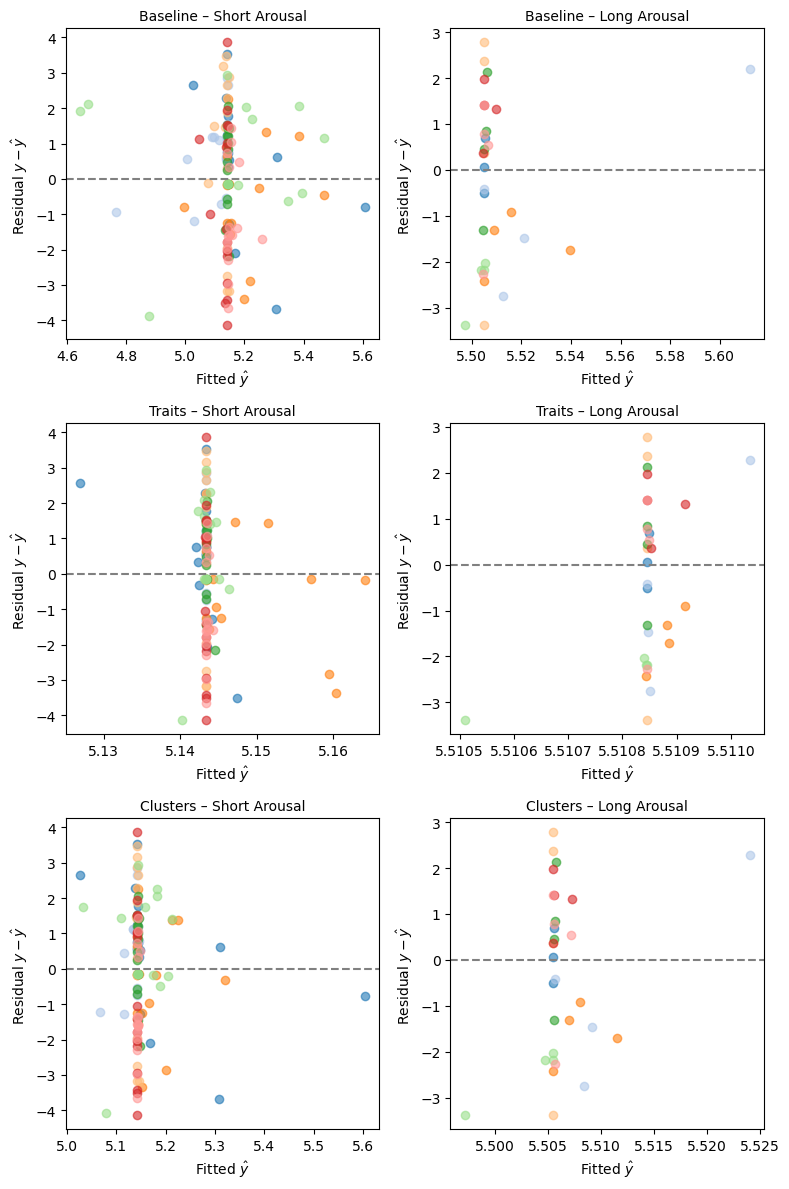

In [ ]:
tasks_by_type = {
    "arousal": ["short-arousal", "long-arousal"],
    "valence": ["short-valence", "long-valence"]
}
settings = ["no_personality", "traits", "PC_clusters"]
algo     = "SVR"

label_mapping = {
    "no_personality": "Baseline",
    "traits": "Traits", 
    "PC_clusters": "Clusters",
    "arousal": "Arousal",
    "valence": "Valence"
}

# create grid of subplots
fig, axes = plt.subplots(
    nrows=len(settings),
    ncols=len(tasks_by_type["arousal"]), # change this to either arousal or valence
    figsize=(4 * len(tasks_by_type["arousal"]), 4 * len(settings)),
    squeeze=False
)

# ------------------------------------------
# NEW plotting loop with readable subtitles
# ------------------------------------------
for i, setting in enumerate(settings):
    for j, task in enumerate(tasks_by_type["arousal"]):   # either arousal or valence
        ax = axes[i][j]

        # — metrics ----------------------------------------------------------
        met = results_by_personality[setting]["results"]["regression"][(algo, task)]["metrics"]
        df_pred = pd.DataFrame(
            {
                "y_pred": met["y_pred"],
                "resid":  np.array(met["y_true"]) - np.array(met["y_pred"]),
                "group":  met["groups"],
            }
        )

        # — scatter plot -----------------------------------------------------
        cmap   = plt.get_cmap("tab20")
        groups = df_pred.group.unique()
        for idx, grp in enumerate(groups):
            sub = df_pred[df_pred.group == grp]
            ax.scatter(
                sub.y_pred,
                sub.resid,
                color=cmap(idx % cmap.N),
                alpha=0.6,
                label=str(grp),
            )

        ax.axhline(0, linestyle="--", color="gray")
        ax.set_xlabel(r"Fitted $\hat y$")
        ax.set_ylabel(r"Residual $y - \hat y$")

        # — ***NEW title with readable labels*** -----------------------------
        setting_name = label_mapping.get(setting, setting)
        split_task   = task.split("-")           # ["short", "arousal"]
        vid_len      = split_task[0].capitalize()  # "Short" / "Long"
        task_type    = label_mapping.get(split_task[1], split_task[1].title())
        ax.set_title(f"{setting_name} – {vid_len} {task_type}", fontsize=10)

        # optional: keep row annotation if you still want it on the side
        # ax.annotate(...)

        # # — legend (unchanged) ----------------------------------------------
        # if j == len(tasks_by_type["arousal"]) - 1:
        #     ax.legend(
        #         bbox_to_anchor=(1.05, 1),
        #         loc="upper left",
        #         title="Group ID",
        #         fontsize="small",
        #         frameon=False,
        #     )

# fig.suptitle("Arousal: Residuals vs. Fitted", y=1.02)
plt.tight_layout()
plt.show()


in the short videos (arousal), residuals scatter somewhat symmetrically around zero without a clear curvature.
In the long videos (arousal), fitted values are very compressed.
No homoscedasticity: variance seems roughly constant across fitted values. few outliers present

## QQ plot for arousal & valence
= to see the residuals versus the theoretical quantiles of a standard normal dist. If the residuals are normal, the points would fall exactly on the red 45° line.

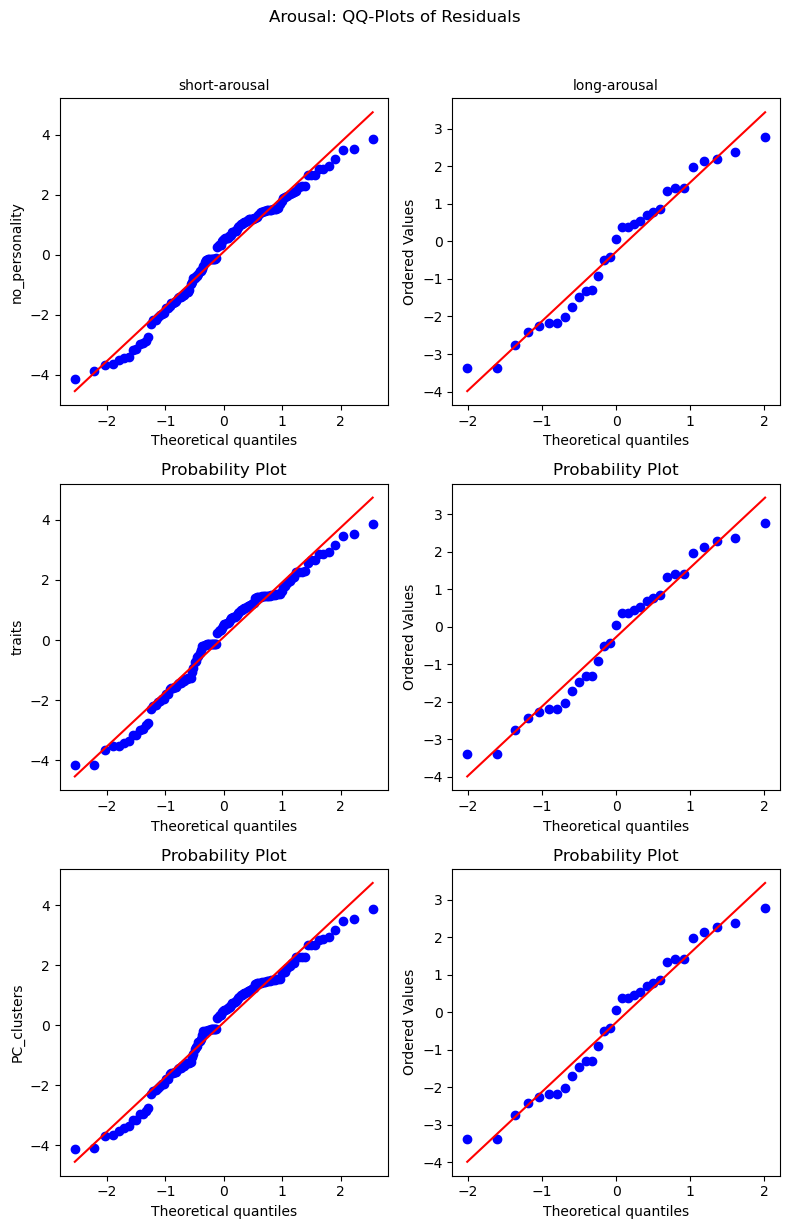

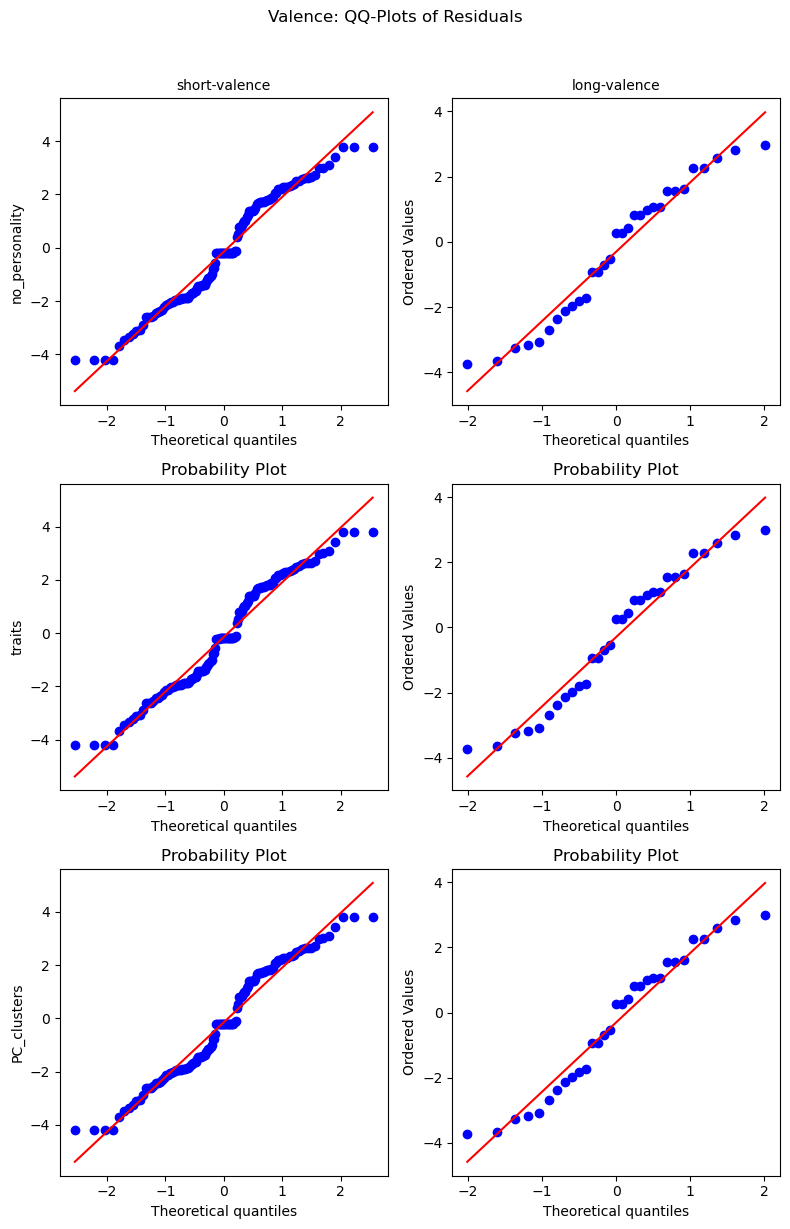

In [ ]:
# arousal
fig, axes = plt.subplots(
    nrows=len(settings),
    ncols=len(tasks_by_type["arousal"]),
    figsize=(4*len(tasks_by_type["arousal"]), 4*len(settings)),
    squeeze=False
)

for i, setting in enumerate(settings):
    for j, task in enumerate(tasks_by_type["arousal"]):
        ax = axes[i][j]
        met   = results_by_personality[setting]["results"]["regression"][(algo, task)]["metrics"]
        resid = np.array(met["y_true"]) - np.array(met["y_pred"])
        stats.probplot(resid, dist="norm", plot=ax)
        if i==0: ax.set_title(task, fontsize=10)
        if j==0: ax.set_ylabel(setting)

fig.suptitle("Arousal: QQ‐Plots of Residuals", y=1.02)
plt.tight_layout()
plt.show()

# valence
fig, axes = plt.subplots(
    nrows=len(settings),
    ncols=len(tasks_by_type["valence"]),
    figsize=(4*len(tasks_by_type["valence"]), 4*len(settings)),
    squeeze=False
)

for i, setting in enumerate(settings):
    for j, task in enumerate(tasks_by_type["valence"]):
        ax = axes[i][j]
        met   = results_by_personality[setting]["results"]["regression"][(algo, task)]["metrics"]
        resid = np.array(met["y_true"]) - np.array(met["y_pred"])
        stats.probplot(resid, dist="norm", plot=ax)
        if i==0: ax.set_title(task, fontsize=10)
        if j==0: ax.set_ylabel(setting)

fig.suptitle("Valence: QQ‐Plots of Residuals", y=1.02)
plt.tight_layout()
plt.show()



Arousal: pretty normal
Valence: most errors are normal, but tails seem to deviate a lot


## Feature correlations 

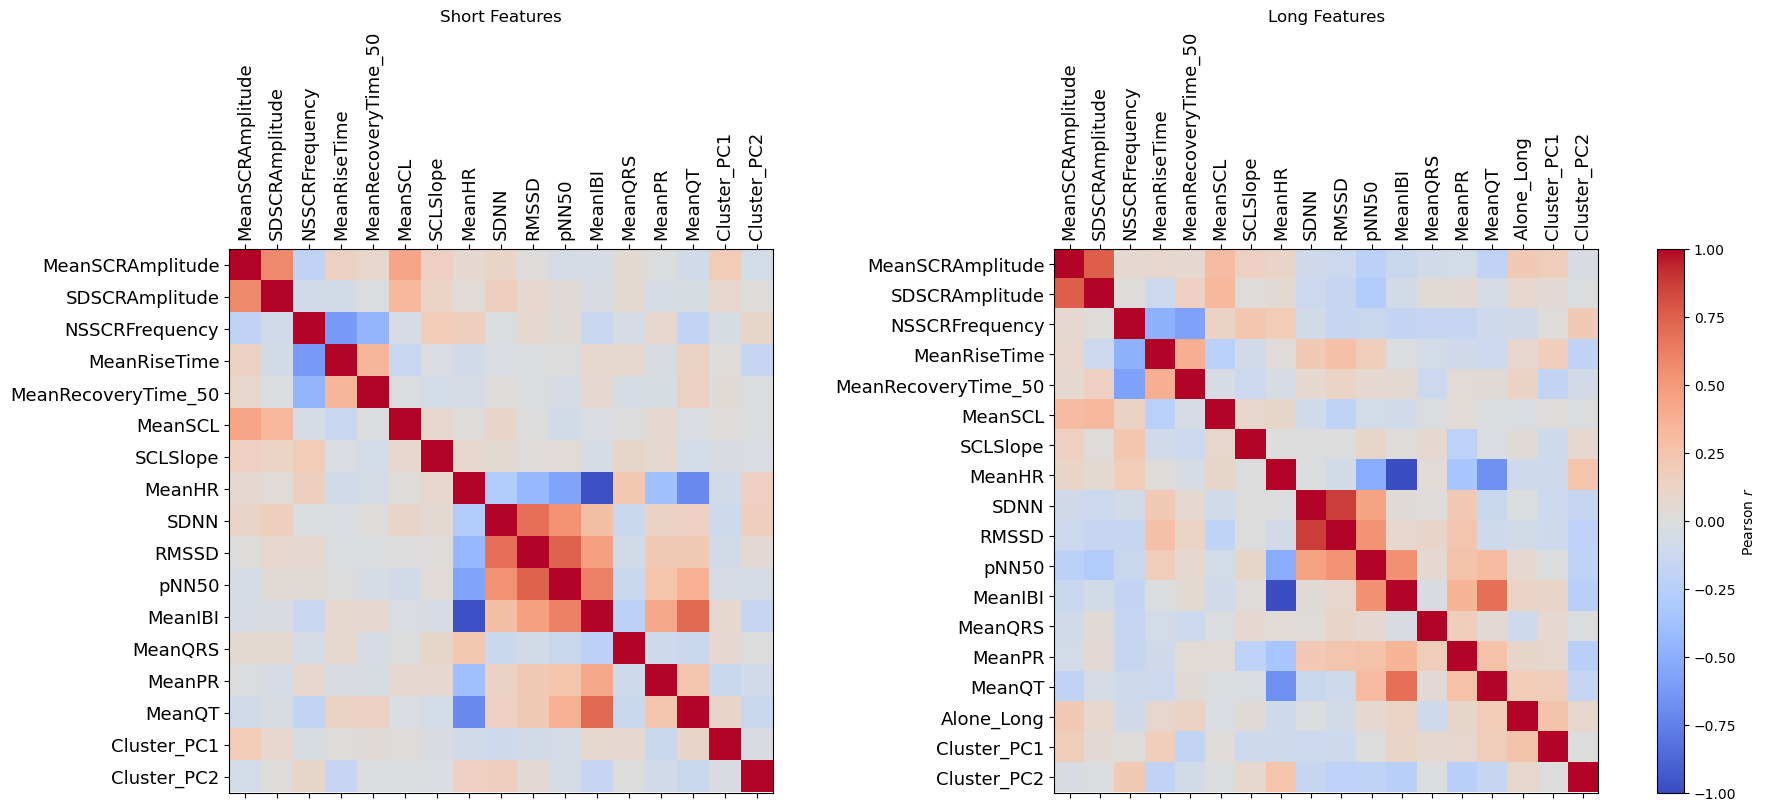

In [11]:
setting = "Clusters"
df_short = results_by_personality[setting]["labeled_short"]
df_long  = results_by_personality[setting]["labeled_long"]

# Drop unwanted columns
drop_cols = ["Cluster", "PC1", "PC2", "arousal", "valence", "Arousal_z", "Valence_z"]
feat_short = df_short.select_dtypes(include=np.number).drop(columns=drop_cols, errors="ignore")
feat_long  = df_long.select_dtypes(include=np.number).drop(columns=drop_cols, errors="ignore")

# Rename columns (example: use real names if needed)
rename_dict = {
    'HR_mean': 'MeanHR',
    'Mean_IBI': 'MeanIBI',
    'QRS_mean': 'MeanQRS',
    'QT_mean': 'MeanQT',
    'PR_mean': 'MeanPR',
    'Alone_long': 'Alone_Long'
}
feat_short = feat_short.rename(columns=rename_dict)
feat_long  = feat_long.rename(columns=rename_dict)

# Correlation
corr_short = feat_short.corr()
corr_long  = feat_long.corr()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(18, 8), constrained_layout=True)

for ax, corr, title in zip(axes, (corr_short, corr_long), ("Short Features", "Long Features")):
    im = ax.matshow(corr, vmin=-1, vmax=1, cmap="coolwarm")
    ax.set_title(title)
    ticks = np.arange(len(corr.columns))
    ax.set_xticks(ticks)
    ax.set_xticklabels(corr.columns, rotation=90, fontsize=13)
    ax.set_yticks(ticks)
    ax.set_yticklabels(corr.columns, fontsize=13)

fig.colorbar(im, ax=axes, fraction=0.02, pad=0.04, label="Pearson $r$")
plt.show()


In [12]:
std_col_a = df_short['arousal'].std()
std_col_b = df_short['valence'].std()

print(f"Standard Deviation of arousal: {std_col_a}")
print(f"Standard Deviation of valence: {std_col_b}")

Standard Deviation of arousal: 1.781746033017096
Standard Deviation of valence: 2.277620110223585


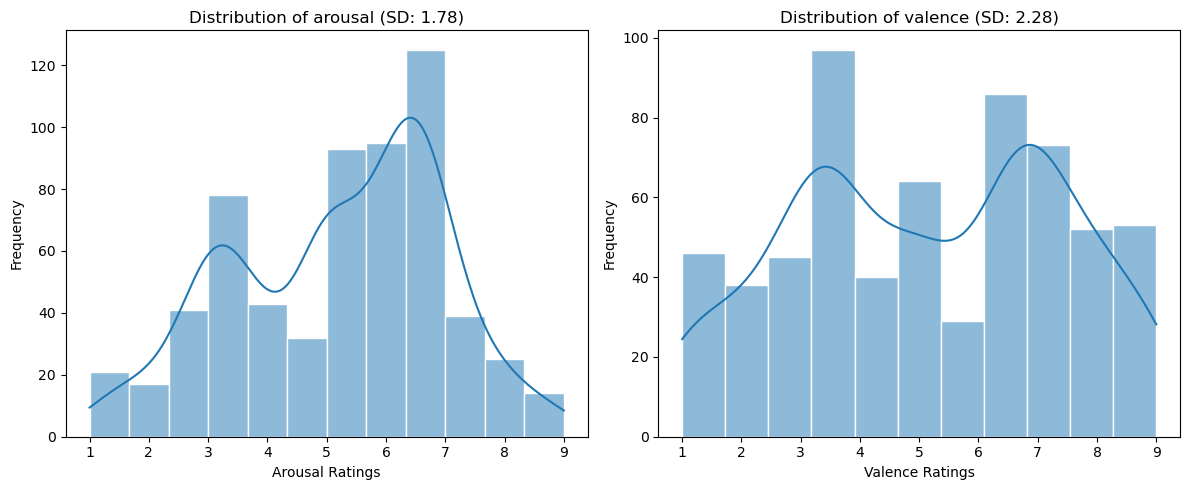

In [13]:
plt.figure(figsize=(12, 5))

# Plot for ColumnA
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
sns.histplot(df_short['arousal'], kde=True, edgecolor="white")
plt.title(f'Distribution of arousal (SD: {std_col_a:.2f})')
plt.xlabel('Arousal Ratings')
plt.ylabel('Frequency')

# Plot for ColumnB
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
sns.histplot(df_short['valence'], kde=True, edgecolor="white")
plt.title(f'Distribution of valence (SD: {std_col_b:.2f})')
plt.xlabel('Valence Ratings')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [15]:
# Step 1: Compute correlation matrices
corr_short_full = df_short[feat_short_ordered + ["arousal", "valence"]].corr()
corr_long_full  = df_long[feat_long_ordered + ["arousal", "valence"]].corr()

# Step 2: Extract only feature-label correlations (rows: features, columns: arousal/valence)
corr_short = corr_short_full.loc[feat_short_ordered, ["arousal", "valence"]]
corr_long  = corr_long_full.loc[feat_long_ordered,  ["arousal", "valence"]]

# Step 3: Rename for display
row_rename_map = {
    "HR_mean": "MeanHR",
    "PR_mean": "MeanPR",
    "QT_mean": "MeanQT",
    "Mean_IBI": "MeanIBI",
    "QRS_mean": "MeanQRS"
}
col_rename_map = {
    "arousal": "Arousal",
    "valence": "Valence"
}

corr_short = corr_short.rename(index=row_rename_map, columns=col_rename_map)
corr_long  = corr_long.rename(index=row_rename_map, columns=col_rename_map)

# Step 4: Plot with font size adjustments
fig, axes = plt.subplots(1, 2, figsize=(14, 8), gridspec_kw={'width_ratios': [1, 1]}, constrained_layout=True)

# Short Videos
sns.heatmap(
    corr_short,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    ax=axes[0],
    cbar=False,
    annot_kws={"size": 12}  # annotation text size
)
axes[0].set_title("Short Videos", pad=10, fontsize=12)
axes[0].tick_params(labelsize=12)

# Long Videos
sns.heatmap(
    corr_long,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    cbar_kws={"ticks": [-1, -0.5, 0, 0.5, 1]},
    ax=axes[1],
    annot_kws={"size": 12}
)
axes[1].set_title("Long Videos", pad=10, fontsize=12)
axes[1].tick_params(labelsize=12)

plt.show()



NameError: name 'feat_short_ordered' is not defined

In [18]:
pers_df = pd.read_pickle("/Users/anna/Downloads/Scriptie_code/Code/notebooks/cluster_pca_features.pkl")

In [21]:
# Step 1: Average arousal and valence per participant
short_avg = df_short.groupby("ParticipantID")[["arousal", "valence"]].mean().reset_index()
long_avg  = df_long.groupby("ParticipantID")[["arousal", "valence"]].mean().reset_index()

# Step 2: Merge with personality and cluster PCA data
merged_short = pers_df.merge(short_avg, on="ParticipantID", how="inner")
merged_long  = pers_df.merge(long_avg,  on="ParticipantID", how="inner")

# Step 3: Compute correlation matrices
corr_short = merged_short.corr(numeric_only=True)
corr_long  = merged_long.corr(numeric_only=True)

# Step 4: Select only personality and PC features as rows
traits_and_pc = ["Extroversion", "Agreeableness", "Conscientiousness", "Openness", "Neuroticism", "Cluster_PC1"]
correlations_short = corr_short.loc[traits_and_pc, ["arousal", "valence"]].rename(columns={"arousal": "Arousal", "valence": "Valence"}).round(2)
correlations_long  = corr_long.loc[traits_and_pc,  ["arousal", "valence"]].rename(columns={"arousal": "Arousal", "valence": "Valence"}).round(2)


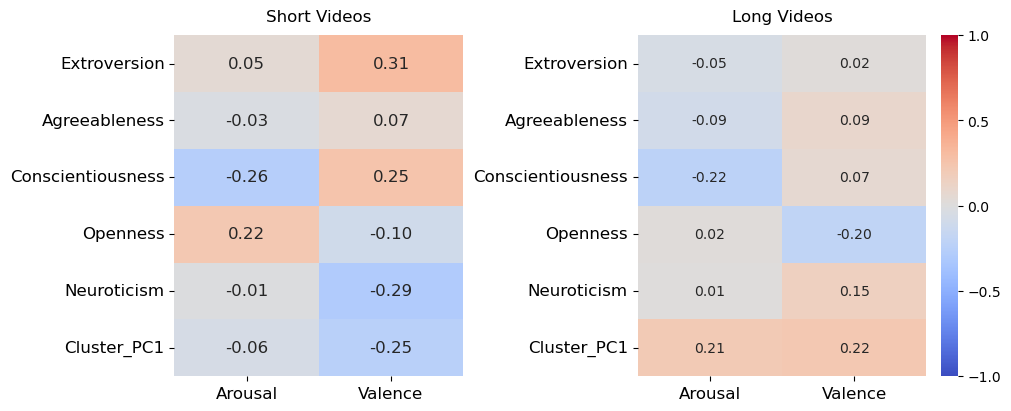

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

sns.heatmap(
    correlations_short,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    ax=axes[0],
    cbar=False,
    annot_kws={"size": 12}  # font size inside heatmap
)
axes[0].set_title("Short Videos", pad=10, fontsize=12)
axes[0].tick_params(labelsize=12)  # axis labels

sns.heatmap(
    correlations_long,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    cbar_kws={"ticks": [-1, -0.5, 0, 0.5, 1]},
    ax=axes[1],
    annot_kws={"size": 10}
)
axes[1].set_title("Long Videos", pad=10, fontsize=12)
axes[1].tick_params(labelsize=12)


plt.show()


In [ ]:
# Ensure participant IDs match in type
labels_z["ParticipantID"] = labels_z["ParticipantID"].astype(int)

# Step 1: Average arousal and valence per participant
labels_avg = labels_z.groupby("ParticipantID")[["arousal", "valence"]].mean().reset_index()

# Step 2: Merge with personality data
pers_merged = pers_df.merge(labels_avg, on="ParticipantID", how="inner")

# Step 3: Compute correlation matrix
cor_matrix = pers_merged.corr(numeric_only=True)

# Step 4: Select and reorder specific traits
trait_order = [
    "Extroversion",
    "Agreeableness",
    "Conscientiousness",
    "Openness",
    "Neuroticism",
    "Cluster_PC1",
    "Cluster_PC2"
]
correlations = cor_matrix.loc[trait_order, ["arousal", "valence"]].round(2)

# Step 5: Plot heatmap with fixed color scale and clean sidebar
plt.figure(figsize=(6, len(correlations) * 0.5))
sns.heatmap(
    correlations,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    vmin=-1,
    vmax=1,
    cbar_kws={"ticks": [-1, -0.5, 0, 0.5, 1]}
)
# plt.title("Correlation of Personality Traits with Arousal and Valence")
plt.tight_layout()
plt.show()


NameError: name 'labels_z' is not defined

Some fetures are somewhat promising, like SCLSlope in the short arousal videos. How come we see a lot of somewhat related features 
- correlation is not equal to predictability under LOPO: r is a global measure across samples, if a features relationship to arousal varies substantially from person to person.
- averaging the features over longer periods of time can ignore the temporal changes someone goes through 

# How does the model perform per participant?

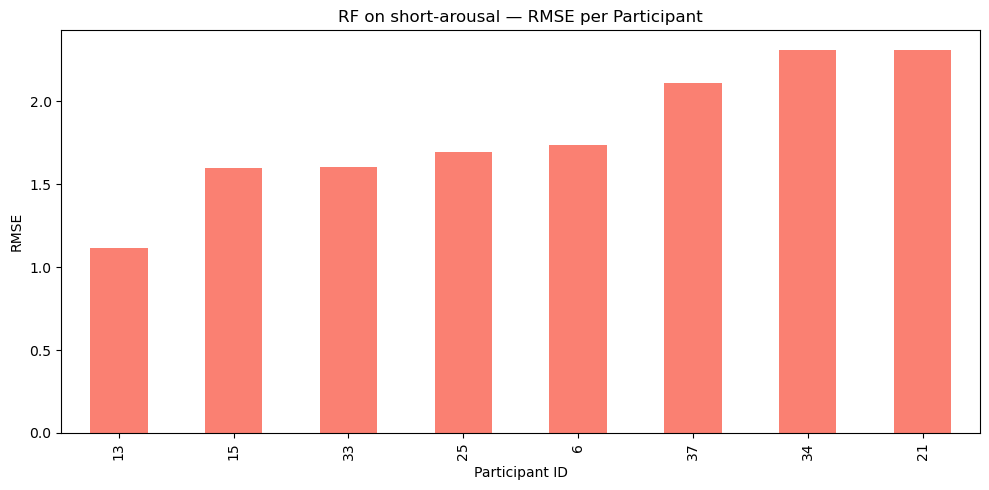

In [ ]:
setting = "PC_clusters" # change
task    = "short-arousal"
algo    = "RF"  # or SVM

met = results_by_personality[setting]["results"]["regression"][(algo, task)]["metrics"]

# Create DataFrame from predictions
df = pd.DataFrame({
    "y_true":  met["y_true"],
    "y_pred":  met["y_pred"],
    "group":   met["groups"].astype(str)
})

# Compute RMSE per participant
df["squared_error"] = (df["y_true"] - df["y_pred"])**2
rmse_per_participant = df.groupby("group")["squared_error"].mean().pow(0.5)

# Plot
plt.figure(figsize=(10, 5))
rmse_per_participant.sort_values().plot(kind="bar", color="salmon")
plt.ylabel("RMSE")
plt.xlabel("Participant ID")
plt.title(f"{algo} on {task} — RMSE per Participant")
plt.tight_layout()
plt.show()


We see that indeed, the model has a lot of variance in predicting people -> could this between people variance explain the low r?
For long videos, the difference is much bigger than for short videos -> makes sense?

# How does the model perform differently per VideoID?

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- SHORT ---
met_short = results_by_personality[setting]["results"]["regression"][("RF", "short-arousal")]["metrics"]
df_short = pd.DataFrame({
    "y_true":  met_short["y_true"],
    "y_pred":  met_short["y_pred"],
    "VideoID": pd.to_numeric(met_short["y_video"], errors="coerce")
})
rmse_short = (
    df_short.groupby("VideoID")
    .apply(lambda x: np.sqrt(((x.y_true - x.y_pred)**2).mean()))
    .rename("Short_RMSE")
)

# --- LONG ---
met_long = results_by_personality[setting]["results"]["regression"][("RF", "long-arousal")]["metrics"]
df_long = pd.DataFrame({
    "y_true":  met_long["y_true"],
    "y_pred":  met_long["y_pred"],
    "VideoID": pd.to_numeric(met_long["y_video"], errors="coerce")
})
rmse_long = (
    df_long.groupby("VideoID")
    .apply(lambda x: np.sqrt(((x.y_true - x.y_pred)**2).mean()))
    .rename("Long_RMSE")
)

# --- Combine and sort ---
rmse_both = pd.concat([rmse_short, rmse_long], axis=1).sort_index()

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 5))
indices = np.arange(len(rmse_both))
width = 0.35

ax.bar(indices - width/2, rmse_both["Short_RMSE"], width, label="Short Videos", alpha=0.8, color="salmon")
ax.bar(indices + width/2, rmse_both["Long_RMSE"],  width, label="Long Videos",  alpha=0.8, color="skyblue")

# Labels & legend
ax.set_xticks(indices)
ax.set_xticklabels(rmse_both.index.astype(int), rotation=90)
ax.set_ylabel("RMSE")
ax.set_xlabel("Video ID")
ax.set_title("RF on Arousal Prediction\nRMSE per Video (Short vs. Long)")
ax.legend()

plt.tight_layout()
plt.show()


/var/folders/ry/fx9j7t7j6sg5lzcmsnqr0pk00000gn/T/ipykernel_22208/31242129.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_short.groupby("VideoID")
/var/folders/ry/fx9j7t7j6sg5lzcmsnqr0pk00000gn/T/ipykernel_22208/31242129.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_long.groupby("VideoID")


TypeError: Index(...) must be called with a collection of some kind, 'Long_RMSE' was passed

we see that for certain videos, the model predicts better than others. On some clips, it does really well (clips 19, 34 f.e.), while on others it really struggles (e.g., clip 18)
certain videos are inherently harder for the model, could be because they evoke more individualized or less intense arousal patterns.
Longer videos seem harder across videos, might be because arousal drifts. 

# How are biological signals (features) related to the videos?
Do biological responses differ across videos? -> check correlations

In [ ]:
df_short = results_by_personality[setting]["labeled_short"]
df_long  = results_by_personality[setting]["labeled_long"]

for df in (df_short, df_long):
    df["ParticipantID"] = df["ParticipantID"].astype(str).str.strip()
df_short = df_short[~df_short["ParticipantID"].isin(["8","28"])]
df_long  = df_long[~df_long["ParticipantID"].isin(["8","28"])]

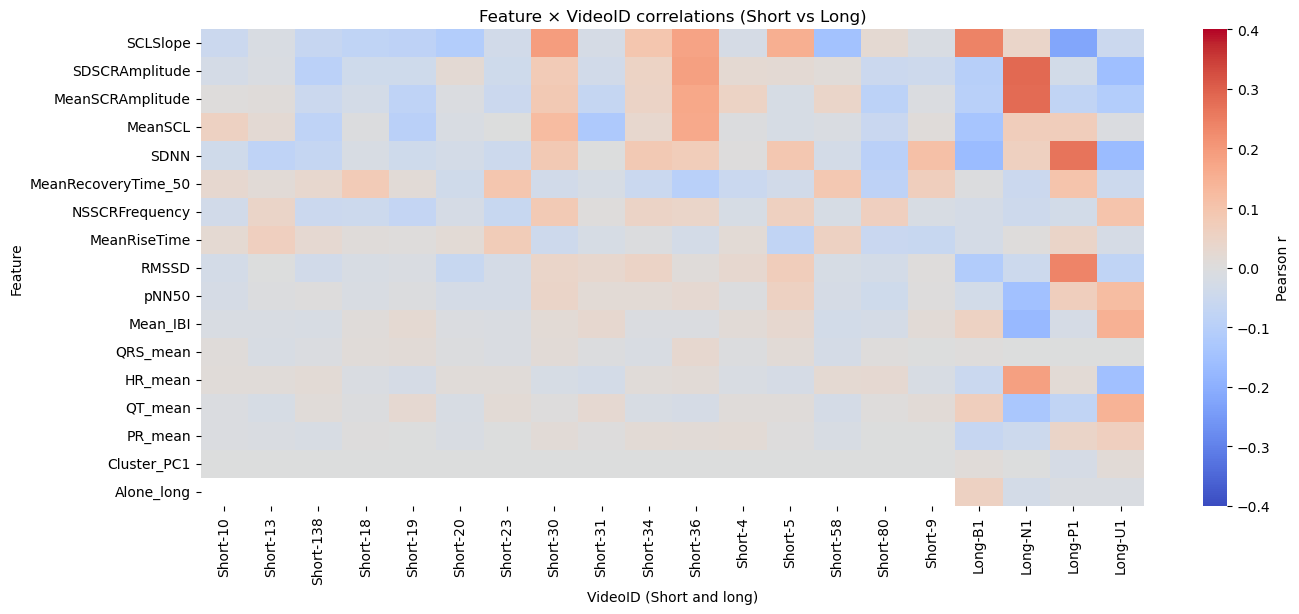

In [ ]:
def feature_video_corr(df):
    id_cols = {"ParticipantID","VideoID",
               "Arousal_z","Valence_z","Cluster_PC2"}
    features = [c for c in df.columns if c not in id_cols] # exclude these columns
    videos = sorted(df["VideoID"].unique(), key=str) # make sure videos appear in order
    # init empty df
    corr = pd.DataFrame(index=features, columns=videos, dtype=float)
    for v in videos: # for each video, compute its dummy correlation with each feature
        y = (df["VideoID"] == v).astype(int) # y is een 0/1 vector
        
        # loop over iedere feature kolom
        for feat in features:
            x = pd.to_numeric(df[feat], errors="coerce") 
            mask = x.notna() & y.notna() # drop NaNs

            if mask.sum() < 3 or y[mask].nunique() == 1 or x[mask].var()==0: # als er te weinig samples zijn -> geen correlatie mogelijk
                corr.at[feat, v] = np.nan                         
            else:
                corr.at[feat, v] = np.corrcoef(x[mask], y[mask])[0,1] # compute r

    # order by the largest absolute r
    feat_order = corr.abs().max(axis=1).fillna(0).sort_values(ascending=False).index # max r per feature across all videos
    return corr.loc[feat_order]


# make two seperate matrices, one long & short
corr_short = feature_video_corr(df_short)
corr_long  = feature_video_corr(df_long)
# concat them for plot
combined = pd.concat(
    [corr_short, corr_long],
    axis=1,
    keys=["Short", "Long"]
)

# uplot
plt.figure(figsize=(14, len(combined)*0.25 + 2))
sns.heatmap(
    combined,
    cmap="coolwarm",
    center=0,
    cbar_kws={"label":"Pearson r"},
    xticklabels=True,
    yticklabels=True,
    vmin=-0.4,     # Set minimum of color range
    vmax=0.4       # Set maximum of color range
)
plt.xlabel("VideoID (Short and long)")
plt.ylabel("Feature")
plt.title("Feature × VideoID correlations (Short vs Long)")
plt.tight_layout()
plt.show()


higher correlations indicate that for these videos, participants had on average higher values for that respective feature. for example, for Long-N1, participants had relatively higher SD of the SCR amplitude, higher Mean SCR amplitude, higher HR mean, which was probably a more stimulating video. 

I sorted the rows by r, so you see which features on average had most correlations across videos. the upper rows are the most discriminative features across videos, lower rows vary little or are noisy.
- important: compare within a row, not across rows. features have different variances -> we should plot this
- maybe anova instead of correlations because we're looking at repeated measures

# Feature variance
variance, or how much that feature fluctuates across persons. Question: how much do biological signals differ across people? -> if this is large, that may explain the poor generalizability. First, we make sure we scale the features map so that variance is 1 over all rows in df_short. this will fix the unit variance across features, but still leaves variance between people. 

# Probleem: je neemt nu de variance van de features van long + short videos samen. is misschien wel oke want we corrigeren voor lengte, maar

In [ ]:
from sklearn.preprocessing import StandardScaler
# select features
id_cols  = {"ParticipantID","VideoID","Arousal_z","Valence_z","Cluster_PC2",
            "y_true","y_pred"}
features = [c for c in df_short.columns if c not in id_cols] # take the columns for the short vids 

# stack short+long into one df for scaling (because this is what we do when modeling as well)
combined = pd.concat(
    [df_short[features], df_long[features]],
    axis=0,
    ignore_index=True
)

# scale
scaler = StandardScaler()
scaler.fit(combined)
# transform seperately
df_short_scaled = df_short.copy()
df_long_scaled  = df_long .copy()
df_short_scaled[features] = scaler.transform(df_short [features])
df_long_scaled [features] = scaler.transform(df_long  [features])

# 1. variance of features across videoids & persons (global)
# variance per feature in long videos vs short videos.
# var_short = df_short_scaled[features].var(ddof=1, skipna=True)
# var_long  = df_long_scaled [features].var(ddof=1, skipna=True)

# variance = pd.concat([var_short, var_long],
#                      axis=1, keys=["Var_Short", "Var_Long"])\
#             .sort_values("Var_Short", ascending=False)

# print(variance)

### Between-video variance
Variance by video: how features differ across videos. (the value of that feature differs a lot over people between videos).
Larger between-variance for a feature means this feature is a good marker for the video. it means that some clips reliably drive up or down the feature in question, 

Logically, Cluster_PC1 is not related to video at all, and this is stable between videos. 

In [ ]:
# variance by video: how features differ across videos
# group by VideoID → compute feature means per video
video_means = (
    df_short_scaled
      .groupby("VideoID", observed=True)[features]
      .mean()
)

# variance across those video-means
between_video_var = video_means.var(ddof=1).sort_values(ascending=False)

print(between_video_var)


SCLSlope               1.952126e-01
MeanSCL                8.943164e-02
MeanSCRAmplitude       7.246066e-02
SDSCRAmplitude         6.973856e-02
MeanRecoveryTime_50    6.417372e-02
SDNN                   4.570035e-02
NSSCRFrequency         3.798245e-02
MeanRiseTime           3.329421e-02
RMSSD                  1.238711e-02
pNN50                  1.050082e-02
Mean_IBI               5.790532e-03
HR_mean                5.683287e-03
QT_mean                4.601553e-03
QRS_mean               3.026442e-03
PR_mean                1.991302e-03
Cluster_PC1            3.209883e-36
dtype: float64


### Between-person variance
how each feature differs from one participant to another (averaging over videos), relative to the global scale of the standardized feature
The value is the squared SD of the participant means data. It's how many standard deviations apart the participants’ means are on average

- values near or over 1 indicate that the the spread of participant means is as large as the overall SD. Participants differ a lot in their average response on this feature.
- Values ≪1: Participant means are tightly clustered around zero, with little between-person variability. This feature is not a stable individual trait; most variation comes within person (across videos). e.g. RMSSD (0.011), SDNN (0.014), MeanSCL (0.004)
- everything inbetween: partial individual differences but also substantial within-person (video-to-video) fluctuations. e.g. PR_mean, Mean_IBI, pNN50.

reminder: I corrected for persons baselines during preprocessing. This means that between-person variance still exists, but rather how people differ in how much they fluctuate from their own means. For example, a feature of a person may average +0.8 SD above their baseline, and another feature of a person only +0.2 SD over their own baseline (because it now reflects relative reactivity instead of absolute). This causes the feature to still have higher inter-person variance. 

In [ ]:
# how feature j differs from one participant to another (averaging over videos)
# instead we group by ParticipantID → compute feature means per person
person_means = (
    df_short_scaled
      .groupby("ParticipantID", observed=True)[features]
      .mean()
)

# 2. variance *across those* person-means
between_person_var = person_means.var(ddof=1).sort_values(ascending=False)

print(between_person_var)


Cluster_PC1            1.031765
HR_mean                1.000431
QT_mean                0.990772
PR_mean                0.978033
Mean_IBI               0.969823
QRS_mean               0.919733
pNN50                  0.698504
MeanRiseTime           0.365457
NSSCRFrequency         0.350494
SDNN                   0.325150
RMSSD                  0.308375
SDSCRAmplitude         0.191806
MeanSCRAmplitude       0.174656
MeanRecoveryTime_50    0.173718
SCLSlope               0.156199
MeanSCL                0.004356
dtype: float64


# ICC (Intra Class Correlation)

In [ ]:
# short_df = results_by_personality["PC_clusters"]["labeled_short"]
# long_df  = results_by_personality["PC_clusters"]["labeled_long"]

n_per_subj = short_df.groupby('ParticipantID').size()
n_bar      = n_per_subj.mean()         # harmonic mean is slightly better; this is fine for n=3–4

icc_vals = {}
for feat in features:
    # grand mean
    grand = short_df[feat].mean()

    # MS_between
    subj_means = short_df.groupby('ParticipantID')[feat].mean()
    ss_between = ((subj_means - grand)**2 * n_per_subj).sum()
    df_between = n_per_subj.count() - 1
    ms_between = ss_between / df_between

    # MS_within
    ss_within  = ((short_df[feat] - short_df.groupby('ParticipantID')[feat].transform('mean'))**2).sum()
    df_within  = len(short_df) - n_per_subj.count()
    ms_within  = ss_within / df_within

    # One-way random-effects ICC(1,1) with unequal n_i
    icc_vals[feat] = (ms_between - ms_within) / (ms_between + (n_bar - 1) * ms_within)

icc_df = pd.Series(icc_vals, name='ICC').to_frame()


In [ ]:
# short_df = results_by_personality["PC_clusters"]["labeled_short"]
# long_df  = results_by_personality["PC_clusters"]["labeled_long"]

n_per_subj = long_df.groupby('ParticipantID').size()
n_bar      = n_per_subj.mean()         # harmonic mean is slightly better; this is fine for n=3–4

icc_vals = {}
for feat in features:
    # grand mean
    grand = long_df[feat].mean()

    # MS_between
    subj_means = long_df.groupby('ParticipantID')[feat].mean()
    ss_between = ((subj_means - grand)**2 * n_per_subj).sum()
    df_between = n_per_subj.count() - 1
    ms_between = ss_between / df_between

    # MS_within
    ss_within  = ((long_df[feat] - long_df.groupby('ParticipantID')[feat].transform('mean'))**2).sum()
    df_within  = len(long_df) - n_per_subj.count()
    ms_within  = ss_within / df_within

    # One-way random-effects ICC(1,1) with unequal n_i
    icc_vals[feat] = (ms_between - ms_within) / (ms_between + (n_bar - 1) * ms_within)

icc_df = pd.Series(icc_vals, name='ICC').to_frame()


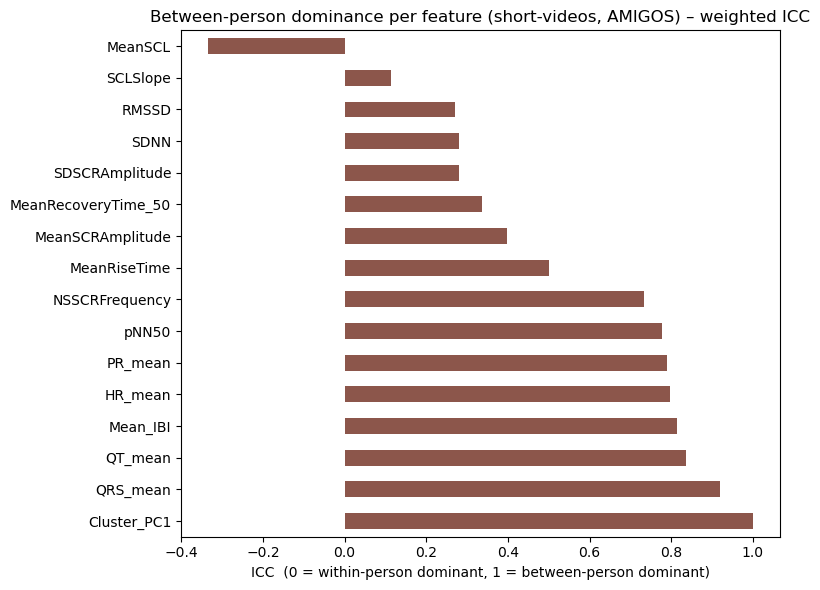

In [ ]:
import matplotlib.pyplot as plt

icc_df['ICC'].sort_values(ascending=False).plot(kind='barh',
                                                figsize=(8,6),
                                                color=plt.get_cmap('tab20')(10))
plt.xlabel("ICC  (0 = within-person dominant, 1 = between-person dominant)")
plt.title("Between-person dominance per feature (short-videos, AMIGOS) – weighted ICC")
plt.tight_layout()
plt.show()




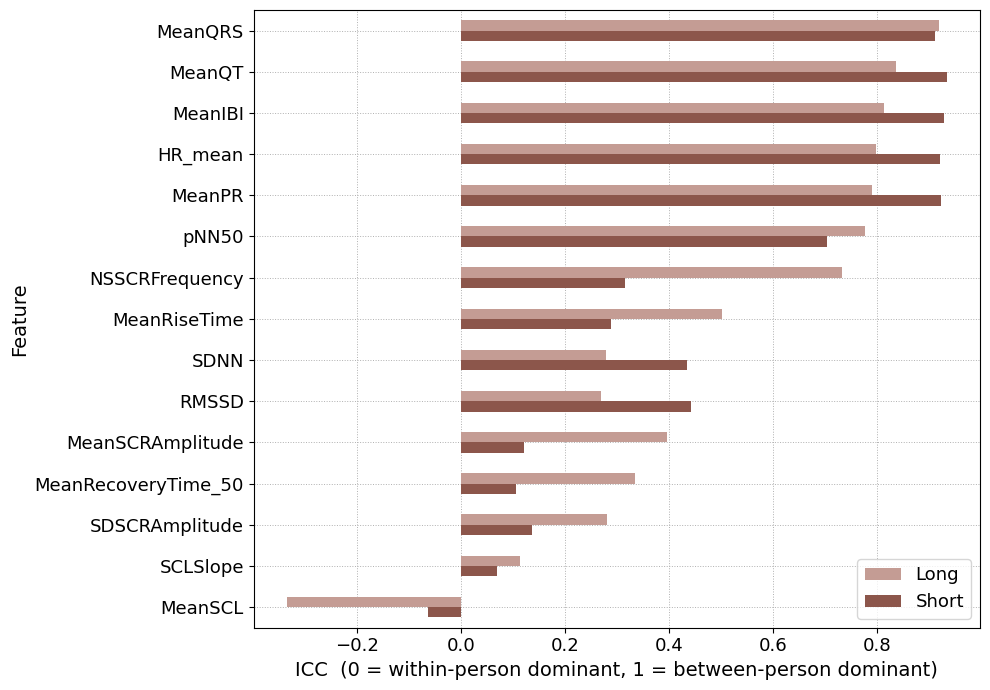

In [ ]:
# Step 1: Drop cluster feature (if still present)
icc_combined = icc_combined.drop(index="Cluster_PC1", errors="ignore")

# Step 2: Sort by mean ICC (optional but useful for visual clarity)
icc_combined["MeanICC"] = icc_combined.mean(axis=1)
icc_combined = icc_combined.sort_values("MeanICC", ascending=False).drop(columns="MeanICC")
icc_combined = icc_combined[["Long", "Short"]]
rename_map = {
    "QRS_mean": "MeanQRS",
    "QT_mean": "MeanQT",
    "Mean_IBI": "MeanIBI",
    "PR_mean": "MeanPR",
    "HR_Mean": "MeanHR"
}

icc_combined = icc_combined.rename(index=rename_map)

# Step 4: Define reversed color order
colors = [plt.get_cmap('tab20')(11), plt.get_cmap('tab20')(10)]  # long = darker, short = lighter

# Step 5: Plot
ax = icc_combined.plot(
    kind="barh",
    figsize=(10, 7),
    color=colors
)

ax.grid(True, linestyle=':', linewidth=0.7)
ax.set_axisbelow(True)


plt.xlabel("ICC  (0 = within-person dominant, 1 = between-person dominant)", fontsize=14)
# plt.title("Between-person dominance per feature – Long vs Short Videos (AMIGOS)")
ax.set_ylabel("Feature", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc="lower right", fontsize=13)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


# Classification results

In [ ]:
rows = []

for setting, content in results_by_personality.items():
    clf_dict = content["results"]["classification"]
    for (algo, task), res in clf_dict.items():
        metrics = res.get("metrics", {})
        if "acc" not in metrics or "auc" not in metrics:
            print(f"⚠️ Missing 'acc' or 'auc' for {setting} | {algo}, {task}")
            continue
        
        row = {
            "Setting":       setting,
            "Algorithm":     algo,
            "Task":          task,
            "Accuracy":      np.mean(metrics.get("acc", [np.nan])),
            "AUC":           np.mean(metrics.get("auc", [np.nan])),
            "F1":            np.mean(metrics.get("f1", [np.nan])),
            "Precision":     np.mean(metrics.get("precision", [np.nan])),
            "Recall":        np.mean(metrics.get("recall", [np.nan])),
            "Balanced_Acc":  np.mean(metrics.get("balanced_acc", [np.nan]))
        }
        
        rows.append(row)

df_clf = pd.DataFrame(rows)
df_clf = df_clf.set_index(["Setting", "Algorithm", "Task"])


In [ ]:
display(df_clf)

Accuracy       AUC        F1  \
Setting        Algorithm Task                                          
no_personality SVC       short-Arousal  0.562500  0.571935  0.569231   
               RF        short-Arousal  0.531250  0.537558  0.565217   
               SVC       short-Valence  0.515625  0.483562  0.523077   
               RF        short-Valence  0.492188  0.505355  0.496124   
               SVC       long-Arousal   0.451613  0.409091  0.484848   
               RF        long-Arousal   0.548387  0.550000  0.500000   
               SVC       long-Valence   0.548387  0.512605  0.416667   
               RF        long-Valence   0.451613  0.357143  0.484848   
traits         SVC       short-Arousal  0.531250  0.560558  0.589041   
               RF        short-Arousal  0.585938  0.518229  0.662420   
               SVC       short-Valence  0.539062  0.433873  0.468468   
               RF        short-Valence  0.523438  0.525031  0.429907   
               SVC       long-Arousal   0.419355  0.527273  0.437500   
               RF        long-Arousal   0.451613  0.477273  0.484848   
               SVC       long-Valence   0.419355  0.546218  0.437500   
               RF        long-Valence   0.483871  0.378151  0.555556   
PC_clusters    SVC       short-Arousal  0.562500  0.506729  0.533333   
               RF        short-Arousal  0.554688  0.558845  0.583942   
               SVC       short-Valence  0.578125  0.490909  0.517857   
               RF        short-Valence  0.476562  0.511582  0.480620   
               SVC       long-Arousal   0.580645  0.250000  0.628571   
               RF        long-Arousal   0.580645  0.540909  0.480000   
               SVC       long-Valence   0.580645  0.336134  0.480000   
               RF        long-Valence   0.419355  0.352941  0.470588   

                                        Precision    Recall  Balanced_Acc  
Setting        Algorithm Task                                              
no_personality SVC       short-Arousal   0.587302  0.552239      0.563005  
               RF        short-Arousal   0.549296  0.582090      0.528750  
               SVC       short-Valence   0.453333  0.618182      0.528269  
               RF        short-Valence   0.432432  0.581818      0.503238  
               SVC       long-Arousal    0.363636  0.727273      0.513636  
               RF        long-Arousal    0.411765  0.636364      0.568182  
               SVC       long-Valence    0.500000  0.357143      0.531513  
               RF        long-Valence    0.421053  0.571429      0.462185  
traits         SVC       short-Arousal   0.544304  0.641791      0.525814  
               RF        short-Arousal   0.577778  0.776119      0.576584  
               SVC       short-Valence   0.464286  0.472727      0.530884  
               RF        short-Valence   0.442308  0.418182      0.510461  
               SVC       long-Arousal    0.333333  0.636364      0.468182  
               RF        long-Arousal    0.363636  0.727273      0.513636  
               SVC       long-Valence    0.388889  0.500000      0.426471  
               RF        long-Valence    0.454545  0.714286      0.504202  
PC_clusters    SVC       short-Arousal   0.603774  0.477612      0.566675  
               RF        short-Arousal   0.571429  0.597015      0.552606  
               SVC       short-Valence   0.508772  0.527273      0.571856  
               RF        short-Valence   0.418919  0.563636      0.487298  
               SVC       long-Arousal    0.458333  1.000000      0.675000  
               RF        long-Arousal    0.428571  0.545455      0.572727  
               SVC       long-Valence    0.545455  0.428571      0.567227  
               RF        long-Valence    0.400000  0.571429      0.432773

In [ ]:
df_clf.sort_values("F1", ascending=False)


Accuracy       AUC        F1  \
Setting        Algorithm Task                                          
traits         RF        short-Arousal  0.585938  0.518229  0.662420   
PC_clusters    SVC       long-Arousal   0.580645  0.250000  0.628571   
traits         SVC       short-Arousal  0.531250  0.560558  0.589041   
PC_clusters    RF        short-Arousal  0.554688  0.558845  0.583942   
no_personality SVC       short-Arousal  0.562500  0.571935  0.569231   
               RF        short-Arousal  0.531250  0.537558  0.565217   
traits         RF        long-Valence   0.483871  0.378151  0.555556   
PC_clusters    SVC       short-Arousal  0.562500  0.506729  0.533333   
no_personality SVC       short-Valence  0.515625  0.483562  0.523077   
PC_clusters    SVC       short-Valence  0.578125  0.490909  0.517857   
no_personality RF        long-Arousal   0.548387  0.550000  0.500000   
                         short-Valence  0.492188  0.505355  0.496124   
               SVC       long-Arousal   0.451613  0.409091  0.484848   
traits         RF        long-Arousal   0.451613  0.477273  0.484848   
no_personality RF        long-Valence   0.451613  0.357143  0.484848   
PC_clusters    RF        short-Valence  0.476562  0.511582  0.480620   
               SVC       long-Valence   0.580645  0.336134  0.480000   
               RF        long-Arousal   0.580645  0.540909  0.480000   
                         long-Valence   0.419355  0.352941  0.470588   
traits         SVC       short-Valence  0.539062  0.433873  0.468468   
                         long-Valence   0.419355  0.546218  0.437500   
                         long-Arousal   0.419355  0.527273  0.437500   
               RF        short-Valence  0.523438  0.525031  0.429907   
no_personality SVC       long-Valence   0.548387  0.512605  0.416667   

                                        Precision    Recall  Balanced_Acc  
Setting        Algorithm Task                                              
traits         RF        short-Arousal   0.577778  0.776119      0.576584  
PC_clusters    SVC       long-Arousal    0.458333  1.000000      0.675000  
traits         SVC       short-Arousal   0.544304  0.641791      0.525814  
PC_clusters    RF        short-Arousal   0.571429  0.597015      0.552606  
no_personality SVC       short-Arousal   0.587302  0.552239      0.563005  
               RF        short-Arousal   0.549296  0.582090      0.528750  
traits         RF        long-Valence    0.454545  0.714286      0.504202  
PC_clusters    SVC       short-Arousal   0.603774  0.477612      0.566675  
no_personality SVC       short-Valence   0.453333  0.618182      0.528269  
PC_clusters    SVC       short-Valence   0.508772  0.527273      0.571856  
no_personality RF        long-Arousal    0.411765  0.636364      0.568182  
                         short-Valence   0.432432  0.581818      0.503238  
               SVC       long-Arousal    0.363636  0.727273      0.513636  
traits         RF        long-Arousal    0.363636  0.727273      0.513636  
no_personality RF        long-Valence    0.421053  0.571429      0.462185  
PC_clusters    RF        short-Valence   0.418919  0.563636      0.487298  
               SVC       long-Valence    0.545455  0.428571      0.567227  
               RF        long-Arousal    0.428571  0.545455      0.572727  
                         long-Valence    0.400000  0.571429      0.432773  
traits         SVC       short-Valence   0.464286  0.472727      0.530884  
                         long-Valence    0.388889  0.500000      0.426471  
                         long-Arousal    0.333333  0.636364      0.468182  
               RF        short-Valence   0.442308  0.418182      0.510461  
no_personality SVC       long-Valence    0.500000  0.357143      0.531513

In [ ]:
# mean accuracy and auc of each setting, comparing the two. So on average, the personality has a slightly higher AUC than no personality
df_clf.groupby("Setting")[["Accuracy","AUC"]].mean()

,Accuracy,AUC
Setting,,
PC_clusters,0.541646,0.443506
no_personality,0.512695,0.490906
traits,0.494235,0.495826


In [ ]:
# average per algorithm: RF outperfomred SVC.
df_clf.groupby(["Setting","Algorithm"])[["Accuracy","AUC"]].mean()

Accuracy       AUC
Setting        Algorithm                    
PC_clusters    RF         0.507812  0.491069
               SVC        0.575479  0.395943
no_personality RF         0.505859  0.487514
               SVC        0.519531  0.494298
traits         RF         0.511215  0.474671
               SVC        0.477256  0.516981

In [ ]:
results_by_personality["no_personality"]["results"]["classification"][("SVC", "short-Arousal")]["metrics"]

{'acc': 0.5625,
 'f1': 0.5692307692307692,
 'precision': 0.5873015873015873,
 'recall': 0.5522388059701493,
 'balanced_acc': 0.563004648886714,
 'auc': 0.5719354049425006,
 'best_params': {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'},
 'cv_results': {'mean_fit_time': array([0.15158865, 0.15475041, 0.15655663, 0.18235286, 0.20696098,
         0.1686278 , 0.17998516, 0.17139808, 0.17864187, 0.19074644,
         0.1687796 , 0.15069855, 0.14659713, 0.19546221, 0.18184394,
         0.12379341, 0.13519342, 0.10999311, 0.10302239, 0.11302451,
         0.10369567, 0.10320153, 0.11198086, 0.16134342, 0.13263508,
         0.19826851, 0.17592965, 0.13568186, 0.11055331, 0.0907062 ]),
  'std_fit_time': array([0.01653922, 0.01262973, 0.01091743, 0.04283973, 0.03944871,
         0.01471365, 0.02836055, 0.02034999, 0.03237986, 0.02135555,
         0.02385584, 0.00989191, 0.00887531, 0.01164021, 0.01768592,
         0.03920328, 0.02137734, 0.01443224, 0.01026272, 0.0216789 ,
         0.008

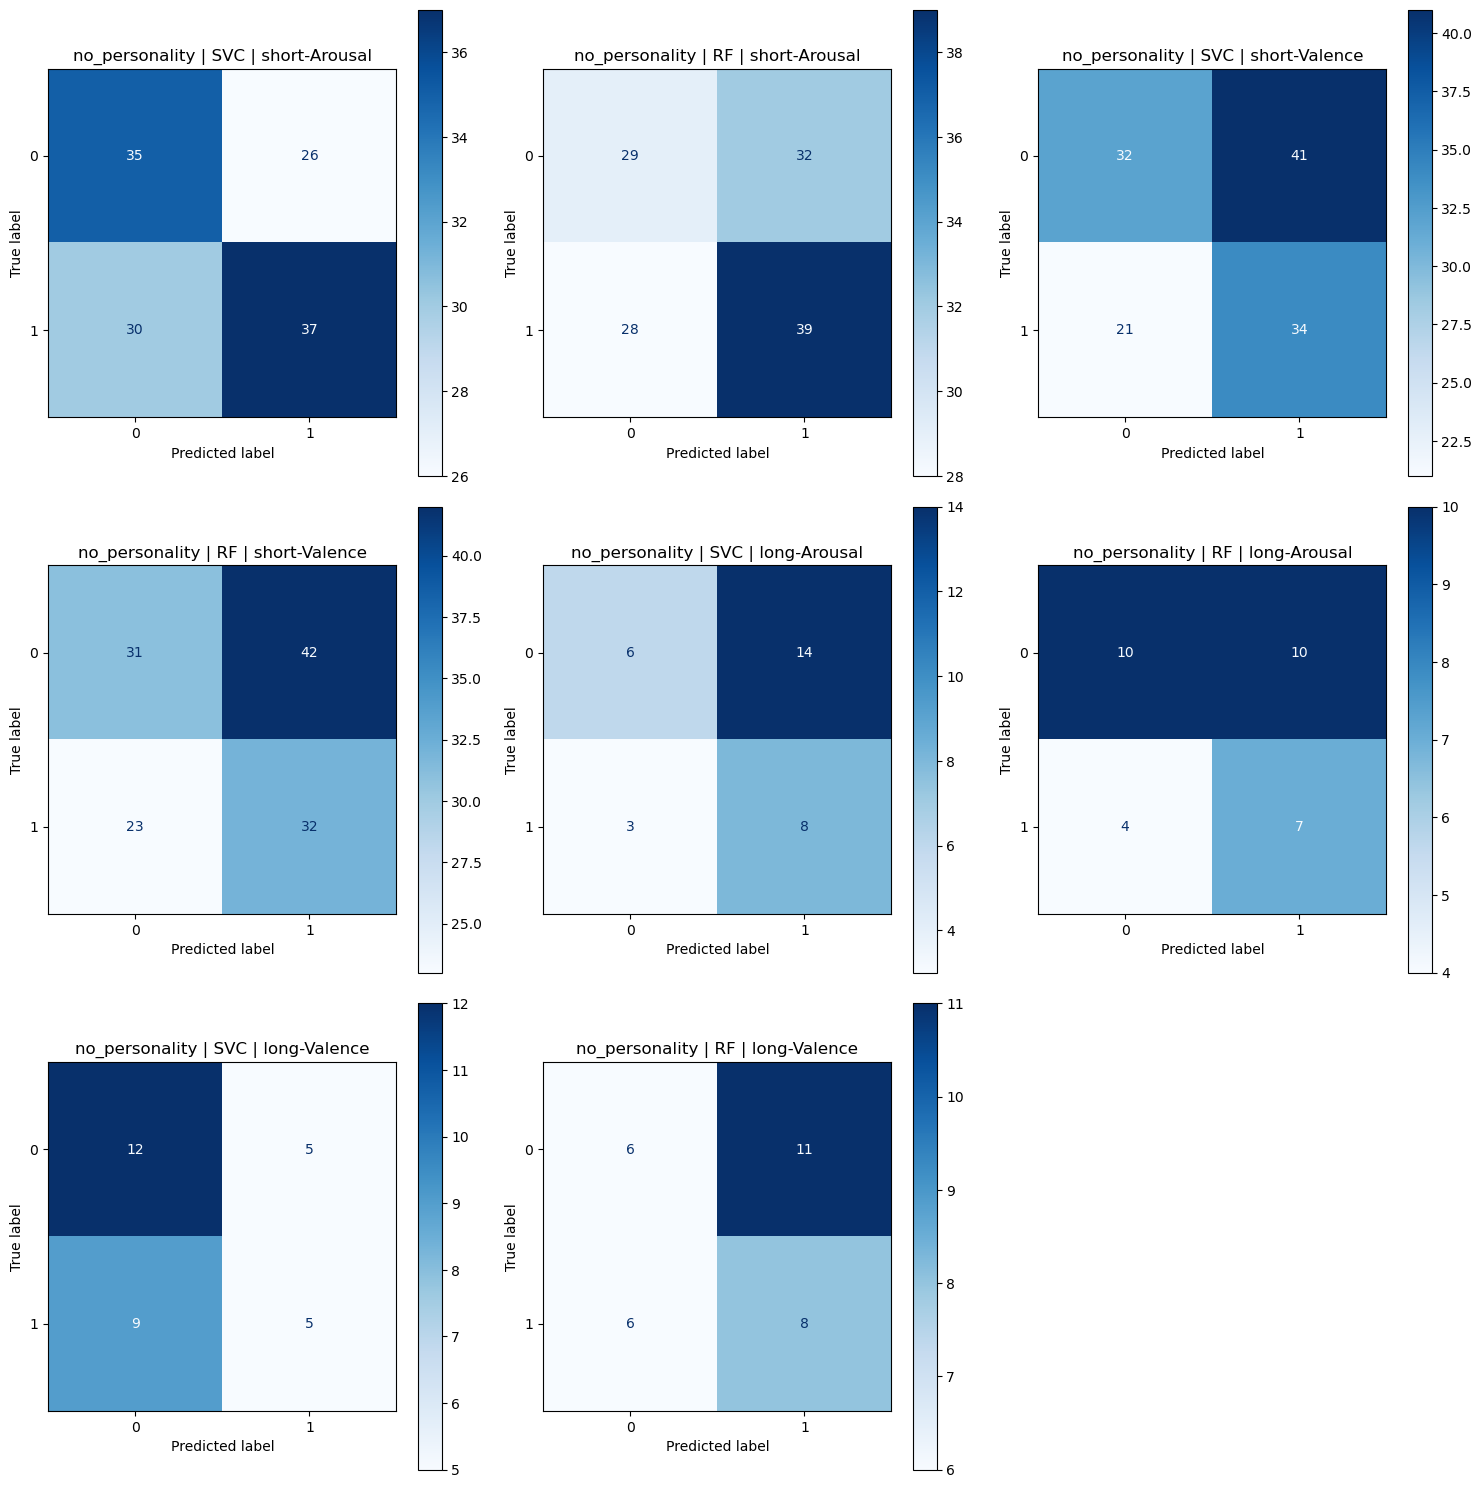

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion(results_by_personality, setting, algo, task, ax=None):
    # Pull out true and predicted labels
    res = results_by_personality[setting]["results"]["classification"][(algo, task)]
    y_true = np.array(res["metrics"]["y_true"])  # FIXED
    y_pred = np.array(res["metrics"]["y_pred"])  # FIXED

    # Determine label set
    labels = np.unique(np.concatenate([y_true, y_pred]))

    # Compute and display confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    ax.set_title(f"{setting} | {algo} | {task}")
    return ax


setting = "no_personality"
clf_dict = results_by_personality[setting]["results"]["classification"]

n = len(clf_dict)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
axes = axes.flatten()

for ax, ((algo, task), _) in zip(axes, clf_dict.items()):
    plot_confusion(results_by_personality, setting, algo, task, ax=ax)

# remove empty matrix
for ax in axes[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from collections import defaultdict
import numpy as np

def print_total_class_distributions(results_by_personality, setting):
    print(f"--- Class Distributions for: {setting} ---\n")
    clf_dict = results_by_personality[setting]["results"]["classification"]

    # Dict: (video_type, task_type) -> list of y_true
    aggregated = defaultdict(list)

    for (algo, task), res in clf_dict.items():
        y_true = np.array(res["metrics"]["y_true"])

        # Infer task type and video type from string
        if "-" in task:
            video_type, task_type = task.split("-")
        else:
            video_type, task_type = "unknown", "unknown"

        aggregated[(video_type, task_type)].append(y_true)

    # Now process each group
    for (video_type, task_type), y_trues in aggregated.items():
        y_all = np.concatenate(y_trues)
        pos = np.sum(y_all == 1)
        neg = np.sum(y_all == 0)
        total = len(y_all)

        print(f"{video_type.capitalize()} videos – {task_type.capitalize()}:")
        print(f"    Positive class: {pos}")
        print(f"    Negative class: {neg}")
        print(f"    Total: {total}")
        print(f"    Balance: {pos} : {neg} (Ratio ≈ {pos / neg:.2f} : 1)\n")


In [ ]:
print_total_class_distributions(results_by_personality, "no_personality")


--- Class Distributions for: no_personality ---

Short videos – Arousal:
    Positive class: 134
    Negative class: 122
    Total: 256
    Balance: 134 : 122 (Ratio ≈ 1.10 : 1)

Short videos – Valence:
    Positive class: 110
    Negative class: 146
    Total: 256
    Balance: 110 : 146 (Ratio ≈ 0.75 : 1)

Long videos – Arousal:
    Positive class: 22
    Negative class: 40
    Total: 62
    Balance: 22 : 40 (Ratio ≈ 0.55 : 1)

Long videos – Valence:
    Positive class: 28
    Negative class: 34
    Total: 62
    Balance: 28 : 34 (Ratio ≈ 0.82 : 1)



In [ ]:
y_true = np.array(res["metrics"]["y_true"])  # FIXED
y_pred = np.array(res["metrics"]["y_pred"])  # FIXED
# Assuming y_train and y_test are 1D numpy arrays or lists
print("Y true", np.bincount(y_true))
print("Y pred", np.bincount(y_pred))

Y true [17 14]
Y pred [11 20]


In [ ]:
y_true = results_by_personality["no_personality"]["results"]["classification"][("RF", "short-Valence")]["metrics"]["y_true"]
print(np.bincount(y_true))  # e.g. array([15, 16])


[73 55]


In [ ]:
# 1. Import your script (make sure it's in the same folder or PYTHONPATH)
from models import make_binary_labels, load_AMIGOS_data, process_labels_amigos, zscore_targets, prepare_dataset

# ---- Config Paths (reuse same logic) ----
DATA_DIR = "/Users/anna/Downloads/Scriptie_code/Amigos/Physiological Data Preprocessed"
METADATA_PATH = "/Users/anna/Downloads/Scriptie_code/Amigos/Metadata/Participant_Questionnaires.xlsx"
MERGED_SHORT_PKL = "/Users/anna/Downloads/Scriptie_code/Code/notebooks/AMIGOS_features_s.pkl"
MERGED_LONG_PKL  = "/Users/anna/Downloads/Scriptie_code/Code/notebooks/ANIGOS_features_l.pkl"

# ---- Load Features ----
merged_short = pd.read_pickle(MERGED_SHORT_PKL)
merged_long  = pd.read_pickle(MERGED_LONG_PKL)

# ---- Load Labels ----
mats = load_AMIGOS_data(DATA_DIR)
labels_df = process_labels_amigos(mats)
labels_df = zscore_targets(labels_df)  # apply within-participant z-score normalization

# ---- Merge Features + Labels ----
# This gives X, y, groups, and a merged DataFrame
_, _, _, _, merged_short_labeled, _ = prepare_dataset(merged_short, labels_df)
_, _, _, _, merged_long_labeled,  _ = prepare_dataset(merged_long,  labels_df)

# ---- Add binary labels based on z-scored valence/arousal ----
short_bin = make_binary_labels(merged_short_labeled, labels_z=True)
long_bin  = make_binary_labels(merged_long_labeled,  labels_z=True)

# ---- Count distribution per label ----
print("Short Videos")
print("Arousal:", short_bin["Arousal_bin"].value_counts().to_dict())
print("Valence:", short_bin["Valence_bin"].value_counts().to_dict())

print("Long Videos")
print("Arousal:", long_bin["Arousal_bin"].value_counts().to_dict())
print("Valence:", long_bin["Valence_bin"].value_counts().to_dict())



✅ Short Videos
Arousal: {1: 318, 0: 305}
Valence: {0: 334, 1: 289}

✅ Long Videos
Arousal: {1: 91, 0: 46}
Valence: {1: 79, 0: 58}


# Get best parameters from model output

In [ ]:
METADATA_PATH = "/Users/anna/Downloads/Scriptie_code/Amigos/Metadata/Participant_Questionnaires.xlsx"
session_df = pd.read_excel(METADATA_PATH, sheet_name=0, dtype={"UserID": str})

# How many distinct entries, including NaNs?
session_df["Session_Type_Exp_2"].value_counts(dropna=False)


Session_Type_Exp_2
Group    20
Alone    17
NaN       3
Name: count, dtype: int64

In [ ]:
# extract best parameters
# Extract best_params from regression results
rows = []
for personality, content in results_by_personality.items():
    reg_results = content["results"]["regression"]
    for (model, dataset), result in reg_results.items():
        try:
            best_params = result["metrics"]["best_params"]
            row = {
                "personality": personality,
                "model": model,
                "dataset": dataset,
                **best_params  # unpack the parameters into columns
            }
            rows.append(row)
        except KeyError:
            print(f"Skipping {personality}-{model}-{dataset}: no best_params.")

df_best_params = pd.DataFrame(rows)

int_cols = [
    "rf__n_estimators",
    "rf__max_depth",
    "rf__min_samples_split",
    "rf__min_samples_leaf",
    "svr__degree",
]
# keep only the ones present
int_cols = [c for c in int_cols if c in df_best_params.columns]
# # cast to pandas nullable Int64, which maps NaN→<NA>
for c in int_cols:
    df_best_params[c] = df_best_params[c].astype("Int64")

df_best_params.to_csv("best_params_regression.csv", index=False)
display(df_best_params)


,personality,model,dataset,rf__max_depth,rf__max_features,rf__max_samples,rf__min_samples_leaf,rf__min_samples_split,rf__n_estimators,svr__C,svr__epsilon,svr__gamma,svr__kernel
0,no_personality,RF,short-arousal,5,sqrt,NaN,3,10,200,NaN,NaN,NaN,NaN
1,no_personality,SVR,short-arousal,<NA>,NaN,NaN,<NA>,<NA>,<NA>,10.0,0.1,1.0000,rbf
2,no_personality,RF,short-valence,5,sqrt,NaN,5,2,150,NaN,NaN,NaN,NaN
3,no_personality,SVR,short-valence,<NA>,NaN,NaN,<NA>,<NA>,<NA>,0.1,0.2,0.0001,rbf
4,no_personality,RF,long-arousal,10,sqrt,NaN,5,2,150,NaN,NaN,NaN,NaN
5,no_personality,SVR,long-arousal,<NA>,NaN,NaN,<NA>,<NA>,<NA>,10.0,0.2,1.0000,rbf
6,no_personality,RF,long-valence,5,sqrt,0.8,3,10,150,NaN,NaN,NaN,NaN
7,no_personality,SVR,long-valence,<NA>,NaN,NaN,<NA>,<NA>,<NA>,10.0,0.2,1.0000,rbf
8,traits,RF,short-arousal,5,sqrt,0.8,3,10,200,NaN,NaN,NaN,NaN
9,traits,SVR,short-arousal,<NA>,NaN,NaN,<NA>,<NA>,<NA>,10.0,0.1,1.0000,rbf


In [ ]:
rows_class = []

for personality, content in results_by_personality.items():
    clf_results = content["results"]["classification"]

    for (model, dataset), result in clf_results.items():
        # depending on your patch, best_params may live directly under result
        # or inside result["metrics"]
        best_params = (
            result.get("best_params") or
            result["metrics"].get("best_params")
        )

        if best_params:
            rows_class.append({
                "personality": personality,
                "model": model,          # e.g. "SVC" or "RF"
                "dataset": dataset,      # e.g. "short-Arousal"
                **best_params            # flatten the param dict into columns
            })
        else:
            print(f"Skipping {personality}-{model}-{dataset}: no best_params.")

# ---- build the DataFrame ----
df_best_clf = pd.DataFrame(rows_class)

# optional: cast integer hyper-parameter columns to nullable Int64
int_cols_class = [
    "rf__n_estimators", "rf__max_depth",
    "rf__min_samples_split", "rf__min_samples_leaf",
    "svc__degree"
]
for c in int_cols_class:
    if c in df_best_clf.columns:
        df_best_clf[c] = pd.to_numeric(df_best_clf[c], errors="ignore").astype("Int64")

display(df_best_clf)
df_best_clf.to_csv("best_params_classification.csv", index=False)


/var/folders/ry/fx9j7t7j6sg5lzcmsnqr0pk00000gn/T/ipykernel_22208/1665861449.py:35: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_best_clf[c] = pd.to_numeric(df_best_clf[c], errors="ignore").astype("Int64")
/var/folders/ry/fx9j7t7j6sg5lzcmsnqr0pk00000gn/T/ipykernel_22208/1665861449.py:35: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_best_clf[c] = pd.to_numeric(df_best_clf[c], errors="ignore").astype("Int64")
/var/folders/ry/fx9j7t7j6sg5lzcmsnqr0pk00000gn/T/ipykernel_22208/1665861449.py:35: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_best_clf[c] = pd.to_numeric(df_best_clf[c], errors="ignore").astype("Int64")
/var/folders/ry/fx9j7t

,personality,model,dataset,svc__C,svc__gamma,svc__kernel,rf__class_weight,rf__max_depth,rf__max_features,rf__max_samples,rf__min_samples_leaf,rf__min_samples_split,rf__n_estimators,svc__coef0,svc__degree
0,no_personality,SVC,short-Arousal,10.0,0.001,rbf,NaN,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,<NA>
1,no_personality,RF,short-Arousal,NaN,NaN,NaN,None,7,sqrt,0.8,3,2,200,NaN,<NA>
2,no_personality,SVC,short-Valence,1.0,0.100,rbf,NaN,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,<NA>
3,no_personality,RF,short-Valence,NaN,NaN,NaN,balanced,5,sqrt,0.8,3,10,100,NaN,<NA>
4,no_personality,SVC,long-Arousal,10.0,NaN,poly,NaN,<NA>,NaN,NaN,<NA>,<NA>,<NA>,0.0,3
5,no_personality,RF,long-Arousal,NaN,NaN,NaN,balanced,7,sqrt,NaN,5,2,200,NaN,<NA>
6,no_personality,SVC,long-Valence,10.0,0.010,rbf,NaN,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,<NA>
7,no_personality,RF,long-Valence,NaN,NaN,NaN,balanced,5,sqrt,NaN,3,2,100,NaN,<NA>
8,traits,SVC,short-Arousal,10.0,0.001,rbf,NaN,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,<NA>
9,traits,RF,short-Arousal,NaN,NaN,NaN,balanced,7,0.5,NaN,3,2,100,NaN,<NA>
